In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np 
import re

from sklearn.metrics import precision_recall_curve, mutual_info_score, normalized_mutual_info_score

from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col, when, lower

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from Evaluation import *
from FeatureExtraction import *
from Filter import *
from TestFramework import *
from LPFormulations import *
from CoverageCalculator import *

# Review Previous Work

In [3]:
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        return filter_data(self.data, terms, hashtags, users, locs, mentions)
    
    
class DataPreprocessor():
    def __init__(self, data, topic, load_labled=False, filter_empty_hashtags=False):
        if filter_empty_hashtags == True:
            self.data = data.filter(col("hashtag") != "empty_hashtag")
        else:
            self.data = data

        if load_labled == True:
            labled_dir = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/" + topic
            pos_dir = labled_dir + "/pos"
            topical_tweet_ids = spark.read.parquet(pos_dir)
            topical_tweets = topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(1))
            
            neg_dir = labled_dir + "/neg"
            non_topical_tweet_ids = spark.read.parquet(neg_dir).sample(False, 0.1, 123)
            non_topical_tweets = non_topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(0))

            self.labled_data = topical_tweets.union(non_topical_tweets)
        else:
            self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label"))
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False, ch=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_valid_time)
        validation_set = labled_data.where((col("create_time") > train_valid_time) \
                                           & (col("create_time") <= valid_test_time))
        test_set = labled_data.where(col("create_time") > valid_test_time)
        
        if remove_topic_hashtags == True:
            train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
            valid_hashtags = pd_ordered_hashtag_set[train_valid_split_time:valid_test_split_time]['each_hashtag']\
                                .tolist()
            test_hashtags = pd_ordered_hashtag_set[valid_test_split_time:]['each_hashtag'].tolist()
            
            valid_test_hashtags = valid_hashtags + test_hashtags
            hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in valid_test_hashtags]
            valid_test_hashtags_regex = '|'.join(hashtags_filter)
            if ch == True:
                invalid_train_ids = (training_set.filter(lower(training_set['hashtag']).rlike(valid_test_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            else:
                invalid_train_ids = (training_set.filter(training_set['hashtag'].rlike(valid_test_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()                
            training_set = training_set.where(~col("tweet_id").isin(invalid_train_ids)) 

            train_test_hashtags = train_hashtags + test_hashtags
            hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_test_hashtags]
            train_test_hashtags_regex = '|'.join(hashtags_filter)
            if ch == True:
                invalid_validation_ids = (validation_set.filter(lower(validation_set['hashtag']).rlike(train_test_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            else:
                invalid_validation_ids = (validation_set.filter(validation_set['hashtag'].rlike(train_test_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()

                
            print("Invalid Validation:" + str(len(invalid_validation_ids)))
            validation_set = validation_set.where(~col("tweet_id").isin(invalid_validation_ids))
            
            train_valid_hashtags = train_hashtags + valid_hashtags
            train_valid_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_valid_hashtags]
            train_valid_hashtags_regex = '|'.join(train_valid_hashtags_filter)
            if ch == True:
                invalid_test_ids = (test_set.filter(lower(test_set['hashtag']).rlike(train_valid_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            else:
                invalid_test_ids = (test_set.filter(test_set['hashtag'].rlike(train_test_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()

                
            print("Invalid Test:" + str(len(invalid_test_ids)))
                
            test_set = test_set.where(~col("tweet_id").isin(invalid_test_ids))
        
        if balance_data == True:
            train_pos_count = training_set.where(col("label") == 1).count()
            train_neg_count = training_set.where(col("label") == 0).count()
            train_pos_neg_ratio = float(train_pos_count) / train_neg_count
            
            training_set_balanced = training_set.sampleBy("label", fractions={0: 2*train_pos_neg_ratio, 1: 1}, seed=seed)
            
            valid_pos_count = validation_set.where(col("label") == 1).count()
            valid_neg_count = validation_set.count() - valid_pos_count
            valid_pos_neg_ratio = float(valid_pos_count) / valid_neg_count
            
            validation_set_balanced = validation_set.sampleBy("label", fractions={0.0: valid_pos_neg_ratio, 1.0: 1}, seed=seed)
            
            return training_set, training_set_balanced, validation_set, validation_set_balanced, test_set
            
        return training_set, validation_set, test_set
    
    def temporal_split2(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False, ch=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    

        train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
        valid_hashtags = pd_ordered_hashtag_set[train_valid_split_time:valid_test_split_time]['each_hashtag']\
                            .tolist()
        
        return train_hashtags, valid_hashtags
            

## Data Size Statistics 

In [4]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

In [9]:
topics = ["Social_issue", "Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]
#"Natr_Disaster"]#,
#counts = pd.DataFrame()
for topic in topics:
    dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)
    train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True, balance_data=False)
    
    counts = counts.append(pd.DataFrame([[train.where(col('label') == 0).count(), train.where(col('label') == 1).count()\
                                , valid.where(col('label') == 0).count(), valid.where(col('label') == 1).count()]]))
    

Invalid Validation:19553
Invalid Test:15967
Invalid Validation:28353
Invalid Test:145766
Invalid Validation:88122
Invalid Test:272376
Invalid Validation:3766
Invalid Test:38930
Invalid Validation:4737
Invalid Test:14454
Invalid Validation:42568
Invalid Test:54729
Invalid Validation:1584
Invalid Test:406644


In [10]:
counts

,0,1,2,3
0,7215193,49876,2642254,9459
0,9956811,28137,2887812,150446
0,509922,10002,2186267,23103
0,328256,19176,3693941,158202
0,7013399,162574,1020714,76883
0,2842325,33795,2825153,6217
0,7400215,146276,3082785,50561
0,95603,2628,55744,600


In [46]:
topics = ["Natr_Disaster", "Social_issue", "Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]
topics_names = ["Natural Disasters", "Social Issues", "Space", "Soccer", "Human Disasters", "Tennis", "Health", "LGBT"]

Hashtags

In [78]:
hashtags_pd = pd.DataFrame()
for topic in topics:
    hashtags = list(topic_dict[topic])[:5]
    hashtags = ["#" + h for h in hashtags]
    hashtags_row = pd.DataFrame(hashtags)
    hashtags_pd = pd.concat([hashtags_pd, hashtags_row], axis=1)
    
hashtags_pd.columns = topics_names

In [79]:
hashtags_pd

,Natural Disasters,Social Issues,Space,Soccer,Human Disasters,Tennis,Health,LGBT
0,#julio,#legalized,#houston,#fifa,#redefinenigeria,#nadal,#chanyeolvirusday,#uniteblue
1,#tsunami2004,#michaelbrown,#rocket,#halamadrid,#bombsquad,#usopen13,#uniteblue,#legalizegayma
2,#chileearthquake,#berkeleyprotests,#meteorshower,#englandsoccercup,#malaysiaairlines,#wimbledon2o13,#chikungunya,#gaymoment
3,#hurricaneprep,#44millionabortions,#asteroids,#beckham,#notinmyname,#rafaelnadal,#ebolaresponse,#equalitynow
4,#drought13,#freetheweed,#astronauts,#messi,#mh17,#murraynadal,#healthworkers,#homosexuality


In [80]:
str(hashtags_pd.to_latex()).replace("\n", "").replace("\\\\", "\\")

'\\begin{tabular}{lllllllll}\\toprule{} & Natural Disasters &        Social Issues &          Space &             Soccer &    Human Disasters &          Tennis &             Health &            LGBT \\\\midrule0 &            \\#julio &           \\#legalized &       \\#houston &              \\#fifa &   \\#redefinenigeria &          \\#nadal &  \\#chanyeolvirusday &      \\#uniteblue \\1 &      \\#tsunami2004 &        \\#michaelbrown &        \\#rocket &        \\#halamadrid &         \\#bombsquad &       \\#usopen13 &         \\#uniteblue &  \\#legalizegayma \\2 &  \\#chileearthquake &    \\#berkeleyprotests &  \\#meteorshower &  \\#englandsoccercup &  \\#malaysiaairlines &  \\#wimbledon2o13 &       \\#chikungunya &      \\#gaymoment \\3 &    \\#hurricaneprep &  \\#44millionabortions &     \\#asteroids &           \\#beckham &       \\#notinmyname &    \\#rafaelnadal &     \\#ebolaresponse &    \\#equalitynow \\4 &        \\#drought13 &         \\#freetheweed &    \\#astronauts &     

In [47]:
labled_dir_root = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
split_dir_root = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'

stats_pd = pd.DataFrame()

for i in range(len(topics)):
    topic = topics[i]
    
    labled_dir = labled_dir_root + topic
    pos_dir = labled_dir + "/pos"
    topical_tweet_ids = spark.read.parquet(pos_dir)
    
    test_pd = pd.read_csv(split_dir_root + topic + "/test.csv").dropna()
    test = test_pd.drop_duplicates(subset='term').reset_index()
    test_topical_count = len(test[test.label == 1])
    
    stats_pd = stats_pd.append([[topics_names[i], topical_tweet_ids.count(), test_topical_count]])

stats_pd.columns = ["Topic", "Topical Tweets Count", "Topical Tweets in Test Split"]

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
stats_pd

,Topic,Topical Tweets Count,Topical Tweets in Test Split
0,Natural Disasters,87660,2872
0,Social Issues,374128,34691
0,Space,404967,47179
0,Soccer,1364125,184380
0,Human Disasters,787404,119265
0,Tennis,84500,6954
0,Health,397640,26203
0,LGBT,624710,44668


In [49]:
str(stats_pd.to_latex()).replace("\n", "")

'\\begin{tabular}{llrr}\\toprule{} &              Topic &  Topical Tweets Count &  Topical Tweets in Test Split \\\\\\midrule0 &  Natural Disasters &                 87660 &                          2872 \\\\0 &      Social Issues &                374128 &                         34691 \\\\0 &              Space &                404967 &                         47179 \\\\0 &             Soccer &               1364125 &                        184380 \\\\0 &    Human Disasters &                787404 &                        119265 \\\\0 &             Tennis &                 84500 &                          6954 \\\\0 &             Health &                397640 &                         26203 \\\\0 &               LGBT &                624710 &                         44668 \\\\\\bottomrule\\end{tabular}'

# Performance Results

## Natural Disaster

In [4]:
def get_selected_features(topic, tf, test, num_feat=50):

    domain_stopwords = ['empty_location', 'empty_mention']#,'rt', 'amp', , 'http']
    positive_set, negative_set = get_transformed_data(test, tf.get_pipeline(),\
                                                      stopwords=domain_stopwords)

    num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
        get_coverage(tf.get_pipeline(), positive_set, negative_set)
        
    positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

    num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
        get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)
    
    baseline = topk_features(tf.get_pipeline(), k=num_feat)

    basic = max_cover(feature_positive_coverage_subset, num_positive_subset, k=num_feat)

    if len(test) > 6000:
        test_subset = test.sample(n=6000, random_state=123)
    else:
        test_subset = test

    mi_scores = get_mi_scores(test_subset, tf.get_pipeline(), feature_positive_coverage)    
    num_tweets = len(test_subset)
    num_positives = len(test_subset[test_subset.label == 1])
    mi = max_cover_with_mutual_information_normalized(feature_positive_coverage_subset, \
                                                                        mi_scores, num_positive_subset, \
                                                                        num_positive_subset, k=num_feat)

    greedy = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=num_feat)

    solver = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                               feature_negative_coverage_subset,\
                               num_positive_subset, num_negative_subset,\
                               k=num_feat, time_limit_secs=600)

    return baseline, basic, mi, greedy, solver

In [3]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Natr_Disaster", "Social_issue", "Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]

for topic in topics:
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)

    domain_stopwords = ['empty_location', 'empty_mention']#,'rt', 'amp', , 'http']
    print("cov begin")
    positive_set, negative_set = get_transformed_data(test, tf.get_pipeline(),\
                                                      stopwords=domain_stopwords)
    
    num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
        get_coverage(tf.get_pipeline(), positive_set, negative_set)

    print("Coverage done")   
    if len(test) > 6000:
        test_subset = test.sample(n=6000, random_state=123)
    else:
        test_subset = test

    mi_scores = get_mi_scores(test_subset, tf.get_pipeline(), feature_positive_coverage)    
    
    print("MI done")   
    num_tweets = len(test_subset)
    num_positives = len(test_subset[test_subset.label == 1])
    cilp = greedy_cilp(positive_set, tf.get_pipeline(), k=50)
    wilp = greedy_wilp(positive_set, mi_scores, tf.get_pipeline(), k=50)
    cailp = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50)
    #print("methods ran")
    filtered_cilp = tf.get_filtered_data_by_index(cilp)
    #print("cilp filtered")
    _, _, cilp_avep, _ = tf.run_with_filtered_test_data(filtered_cilp)
    #print("cilp avep")
    filtered_wilp = tf.get_filtered_data_by_index(wilp)
    #print("wilp filtered")
    _, _, wilp_avep, _ = tf.run_with_filtered_test_data(filtered_wilp)    
    #print("wilp avep")

    filtered_cailp = tf.get_filtered_data_by_index(cailp)
    #print("cailp filtered")
    _, _, cailp_avep, _ = tf.run_with_filtered_test_data(filtered_cailp)
    #print("cailp avp")

    results_pd = pd.DataFrame()

    pos = len(test[test.label == 1])
    tot = len(test)

    # CILP
    pos_ret = len(filtered_cilp[filtered_cilp.label == 1])
    tot_ret = len(filtered_cilp)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["CILP", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, cilp_avep]])

    # WILP
    pos_ret = len(filtered_wilp[filtered_wilp.label == 1])
    tot_ret = len(filtered_wilp)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["WILP", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, wilp_avep]])

    # CAILP
    pos_ret = len(filtered_cailp[filtered_cailp.label == 1])
    tot_ret = len(filtered_cailp)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["CAILP", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, cailp_avep]])
        
    results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
    
    print(topic)
    print(results_pd.to_latex())    

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0169708795585
47157
94314
transform done!


/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Coverage done
MI done
methods ran
cilp filtered
cilp avep
wilp filtered
wilp avep
cailp filtered
cailp avp
Space
\begin{tabular}{llrrrrr}
\toprule
{} &  Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &   CILP &              42788 &          1743578 &  0.907352 &   0.024540 &  0.887749 \\
0 &   WILP &              41203 &          1261620 &  0.873741 &   0.032659 &  0.908019 \\
0 &  CAILP &              37877 &            74179 &  0.803211 &   0.510616 &  0.987595 \\
\bottomrule
\end{tabular}



/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0761043055235
184097
368194
transform done!
Coverage done
MI done
methods ran
cilp filtered
cilp avep
wilp filtered
wilp avep
cailp filtered
cailp avp
Soccer
\begin{tabular}{llrrrrr}
\toprule
{} &  Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &   CILP &             165243 &          1652566 &  0.897587 &   0.099992 &  0.956886 \\
0 &   WILP &             166186 &          1222693 &  0.902709 &   0.135918 &  0.969254 \\
0 &  CAILP &             153103 &           299939 &  0.831643 &   0.510447 &  0.982197 \\
\bottomrule
\end{tabular}

Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0813981903124
118583
237166
transform done!
Coverage done
MI done
methods ran
cilp filtered
cilp avep
wilp filtered
wilp avep
cailp filtered
cailp avp
Human_Disaster
\begin{tabular}{llrrrrr}
\toprule
{} &  Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &     

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0307078117246
26237
52474
transform done!
Coverage done
MI done
methods ran
cilp filtered
cilp avep
wilp filtered
wilp avep
cailp filtered
cailp avp
Health
\begin{tabular}{llrrrrr}
\toprule
{} &  Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &   CILP &              24839 &           539705 &  0.946716 &   0.046023 &  0.951150 \\
0 &   WILP &              24731 &           432370 &  0.942600 &   0.057199 &  0.957380 \\
0 &  CAILP &              23349 &            51224 &  0.889926 &   0.455821 &  0.987817 \\
\bottomrule
\end{tabular}

Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0130739932635
44521
89042
transform done!
Coverage done
MI done
methods ran
cilp filtered
cilp avep
wilp filtered
wilp avep
cailp filtered
cailp avp
LGBT
\begin{tabular}{llrrrrr}
\toprule
{} &  Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midr

In [114]:
g_features = [f for f in cilp if f not in wilp]
g_features
get_feature_by_index(tf.get_pipeline(), g_features)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [87]:
get_feature_by_index(tf.get_pipeline(), cilp)

,Feature,Type
0,rt,Term
1,Earthquake,Hashtag
2,amp,Term
3,people,Term
4,http,Term
5,Hurricane,Hashtag
6,Typhoon,Hashtag
7,Storm,Hashtag
8,help,Term
9,Sandy,Hashtag


In [80]:
filtered_cilp = tf.get_filtered_data_by_index(greedy_cilp)
_, _, cilp_avep, _ = tf.run_with_filtered_test_data(filtered_cilp)
    
filtered_wilp = tf.get_filtered_data_by_index(wilp)
_, _, wilp_avep, _ = tf.run_with_filtered_test_data(filtered_wilp)    

In [83]:
pos = len(test[test.label == 1])
tot = len(test)

pos_ret = len(filtered_cilp[filtered_cilp.label == 1])
tot_ret = len(filtered_cilp)
recall = (float)(pos_ret) / pos

pos_ret = len(filtered_wilp[filtered_wilp.label == 1])
tot_ret = len(filtered_wilp)
recall = (float)(pos_ret) / pos


In [85]:
tot_ret

581493

In [50]:
max(mi_scores)

0.24974934778576108

In [31]:

positive_bin = binarize(positive_set)

positive_lil = positive_bin.tolil()


In [59]:
#positive_lil.sum(axis=0) + 
mi_scores_mat = mi_scores_mat * 2
mi_scores_mat[0, 9453]

0.49949869557152216

In [4]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Social_issue", "Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]
#"Natr_Disaster", "Social_issue",
for topic in topics:
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)
    
    baseline, basic, mi, greedy, solver = get_selected_features(topic, tf, test)
    
    _, _, ideal_avep, _ = tf.get_ideal_performance()
    
    filtered_baseline = tf.get_filtered_data_by_index(baseline)
    _, _, baseline_avep, _ = tf.run_with_filtered_test_data(filtered_baseline) 
    
    filtered_basic = tf.get_filtered_data_by_index(basic)
    _, _, basic_avep, _ = tf.run_with_filtered_test_data(filtered_basic)
    
    filtered_mi = tf.get_filtered_data_by_index(mi)
    _, _, mi_avep, _ = tf.run_with_filtered_test_data(filtered_mi)
    
    filtered_greedy = tf.get_filtered_data_by_index(greedy)
    _, _, greedy_avep, _ = tf.run_with_filtered_test_data(filtered_greedy)
    
    filtered_solver = tf.get_filtered_data_by_index(solver)
    _, _, solver_avep, _ = tf.run_with_filtered_test_data(filtered_solver)
    
    
    results_pd = pd.DataFrame()

    # Ideal
    pos = len(test[test.label == 1])
    tot = len(test)
    print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
    print("Number of Tweets w/o duplicates = {0}".format(tot))

    results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

    # Baseline
    pos_ret = len(filtered_baseline[filtered_baseline.label == 1])
    tot_ret = len(filtered_baseline)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["Baseline", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, baseline_avep]])

    # Basic LP
    pos_ret = len(filtered_basic[filtered_basic.label == 1])
    tot_ret = len(filtered_basic)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["Basic LP Formulation", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, basic_avep]])

    # MI 
    pos_ret = len(filtered_mi[filtered_mi.label == 1])
    tot_ret = len(filtered_mi)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP Formulation With Mutual Information", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, mi_avep]])
    
    # Greedy 
    pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
    tot_ret = len(filtered_greedy)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, greedy_avep]])
    
    # Solver 
    pos_ret = len(filtered_solver[filtered_solver.label == 1])
    tot_ret = len(filtered_solver)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, solver_avep]])    
    
    results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
    
    print(topic)
    print(results_pd.to_latex())

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!


/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#pos/#neg = 0.0169708795585
Number of Topical Tweets w/o duplicates= 47157
Number of Tweets w/o duplicates = 2825858
Space
\begin{tabular}{llrrrrr}
\toprule
{} &                                      Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &                                      Ideal &              47157 &          2825858 &  1.000000 &   0.016688 &  0.849296 \\
0 &                                   Baseline &              30701 &            30701 &  0.651038 &   1.000000 &  1.000000 \\
0 &                       Basic LP Formulation &              43601 &          1562269 &  0.924592 &   0.027909 &  0.897641 \\
0 &     LP Formulation With Mutual Information &              40911 &          1198172 &  0.867549 &   0.034145 &  0.911272 \\
0 &  LP with Negative Coverage (Greedy Solver) &              37877 &            74179 &  0.803211 &   0.510616 &  0.987595 \\
0 &  LP with Negative Coverage (Gurobi Solver) &              39784 &  

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
#pos/#neg = 0.0761043055235
Number of Topical Tweets w/o duplicates= 184097
Number of Tweets w/o duplicates = 2603106
Soccer
\begin{tabular}{llrrrrr}
\toprule
{} &                                      Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &                                      Ideal &             184097 &          2603106 &  1.000000 &   0.070722 &  0.942593 \\
0 &                                   Baseline &              96088 &            96088 &  0.521942 &   1.000000 &  1.000000 \\
0 &                       Basic LP Formulation &             171742 &          1542980 &  0.932889 &   0.111305 &  0.964419 \\
0 &     LP Formulation With Mutual Information &             166532 &          1203432 &  0.904588 &   0.138381 &  0.970846 \\
0 &  LP with Negative Coverage (Greedy Solver) &             153103 &           299939 &  0.831643 &   0.510447 &  0.982197 \\
0 &  LP with Negative Coverage 

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
#pos/#neg = 0.0307078117246
Number of Topical Tweets w/o duplicates= 26237
Number of Tweets w/o duplicates = 880645
Health
\begin{tabular}{llrrrrr}
\toprule
{} &                                      Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &                                      Ideal &              26237 &           880645 &  1.000000 &   0.029793 &  0.939070 \\
0 &                                   Baseline &              12829 &            12829 &  0.488966 &   1.000000 &  1.000000 \\
0 &                       Basic LP Formulation &              25671 &           504904 &  0.978427 &   0.050843 &  0.953466 \\
0 &     LP Formulation With Mutual Information &              24621 &           411867 &  0.938408 &   0.059779 &  0.958585 \\
0 &  LP with Negative Coverage (Greedy Solver) &              23349 &            51224 &  0.889926 &   0.455821 &  0.987817 \\
0 &  LP with Negative Coverage (G

In [11]:
results_pd

,0,1,2,3,4,5,AveP,Model,Precision,Recall,Topical Retrieved,Total Retrieved
0,NaN,NaN,NaN,NaN,NaN,NaN,0.627996,Ideal,0.002618,1.000000,2688.0,1026793.0
0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,Baseline,1.000000,0.533482,1434.0,1434.0
0,NaN,NaN,NaN,NaN,NaN,NaN,0.543565,Basic LP Formulation,0.003426,0.710193,1909.0,557284.0
0,NaN,NaN,NaN,NaN,NaN,NaN,0.556213,LP Formulation With Mutual Information,0.003412,0.726562,1953.0,572419.0
0,NaN,NaN,NaN,NaN,NaN,NaN,0.629229,LP with Negative Coverage (Greedy Solver),0.023407,0.446429,1200.0,51267.0
0,NaN,NaN,NaN,NaN,NaN,NaN,0.494283,LP with Negative Coverage (Gurobi Solver),0.074366,0.305432,821.0,11040.0
0,LP with Negative Coverage (Gurobi Solver),2109.0,12412.0,0.784598,0.169916,0.855988,NaN,NaN,NaN,NaN,NaN,NaN


# Get Selected Features

In [5]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Natr_Disaster", "Soccer","Space", "Human_Disaster", "Tennis", "Health", "LGBT", "Social_issue"]

results = 
for topic in topics:
    print(topic)
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training2.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation2.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test2.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)
    
    baseline, basic, mi, _, solver = get_selected_features(topic, tf, test, num_feat=20)
    
    baseline_features = get_feature_by_index(tf.get_pipeline(), baseline)
    basic_features = get_feature_by_index(tf.get_pipeline(), basic)
    mi_features = get_feature_by_index(tf.get_pipeline(), mi)
#    greedy_features = get_feature_by_index(tf.get_pipeline(), greedy)
    solver_features = get_feature_by_index(tf.get_pipeline(), solver)
    
    pd.concat([baseline_features, basic_features, mi_features, solver_features], axis=1)\
          .to_latex()


Natr_Disaster
Initializing Classifier....
Complete!
#pos/#neg = 0.00262473086256
2688
5376
transform done!
\begin{tabular}{lllllllll}
\toprule
{} &                Feature &     Type &     Feature &     Type &     Feature &     Type &     Feature &     Type \\
\midrule
0 &                  storm &  Hashtag &          rt &     Term &      rescue &     Term &  earthquake &  Hashtag \\
1 &  prayforthephilippines &  Hashtag &  earthquake &  Hashtag &          rt &     Term &   hurricane &  Hashtag \\
2 &             earthquake &  Hashtag &   hurricane &  Hashtag &  earthquake &  Hashtag &       sandy &  Hashtag \\
3 &                ukstorm &  Hashtag &       storm &  Hashtag &       quake &  Hashtag &       storm &  Hashtag \\
4 &                  sandy &  Hashtag &     typhoon &  Hashtag &     typhoon &  Hashtag &     typhoon &  Hashtag \\
\bottomrule
\end{tabular}

Soccer


/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
#pos/#neg = 0.0761043055235
184097
368194
transform done!
\begin{tabular}{lllllllll}
\toprule
{} &    Feature &     Type &       Feature &     Type &       Feature &     Type &       Feature &     Type \\
\midrule
0 &   football &  Hashtag &            rt &     Term &            rt &     Term &       arsenal &  Hashtag \\
1 &     sports &  Hashtag &      football &  Hashtag &       arsenal &  Hashtag &    halamadrid &  Hashtag \\
2 &        lfc &  Hashtag &           lfc &  Hashtag &           lfc &  Hashtag &           lfc &  Hashtag \\
3 &  nashville &  Hashtag &      worldcup &  Hashtag &      worldcup &  Hashtag &      worldcup &  Hashtag \\
4 &       nike &  Hashtag &  worldcup2014 &  Hashtag &  worldcup2014 &  Hashtag &  worldcup2014 &  Hashtag \\
\bottomrule
\end{tabular}

Space
Initializing Classifier....
Complete!
#pos/#neg = 0.0169708795585
47157
94314
transform done!
\begin{tabular}{lllllllll}
\toprule
{} &   Feature &     Type &   Featu

In [9]:
domain_stopwords

NameError: name 'domain_stopwords' is not defined

In [22]:
print(pd.concat([baseline_features, basic_features, mi_features, greedy_features, solver_features], axis=1).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &                Feature &     Type &     Feature &     Type &      Feature &     Type &     Feature &     Type &     Feature &     Type \\
\midrule
0 &                  storm &  Hashtag &   hurricane &     Term &       floods &     Term &  Earthquake &  Hashtag &   hurricane &     Term \\
1 &  PrayForThePhilippines &  Hashtag &     kashmir &     Term &      kashmir &     Term &   Hurricane &  Hashtag &     kashmir &     Term \\
2 &             earthquake &  Hashtag &      people &     Term &  philippines &     Term &     Typhoon &  Hashtag &     Drought &  Hashtag \\
3 &                ukstorm &  Hashtag &      Bertha &  Hashtag &       rescue &     Term &       Storm &  Hashtag &  Earthquake &  Hashtag \\
4 &                  Sandy &  Hashtag &  Earthquake &  Hashtag &      typhoon &     Term &       Sandy &  Hashtag &       Flood &  Hashtag \\
5 &                tornado &  Hashtag &       Flood &  Hashtag &      Drought &  Hashtag &   hurrica

# Effect of Varying K

In [12]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Social_issue", "Soccer", "Space", "Human_Disaster", "Tennis", "Health", "LGBT"]#"Natr_Disaster"]
ks = [10, 20, 50, 100, 200]

for topic in topics:
    print(topic)
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)
    
    domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention']
    positive_set, negative_set = get_transformed_data(test, tf.get_pipeline(),\
                                                      stopwords=domain_stopwords)

    num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
        get_coverage(tf.get_pipeline(), positive_set, negative_set)
        
    results_pd = pd.DataFrame()

    pos = len(test[test.label == 1])
    tot = len(test)
    
    for k in ks:
        greedy = greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=k)    
        filtered_greedy = tf.get_filtered_data_by_index(greedy) 
        
        _, _, avep, _ = tf.run_with_filtered_test_data(filtered_greedy)
        
        # Greedy 
        pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
        tot_ret = len(filtered_greedy)
        recall = (float)(pos_ret) / pos

        results_pd = results_pd.append([[k, pos_ret, tot_ret\
                                         , recall, (float)(pos_ret) / tot_ret, avep]])
        
    results_pd.columns = ["K", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
    
    print(results_pd.to_latex())

Social_issue
Initializing Classifier....
Complete!
#pos/#neg = 0.139728744396
\begin{tabular}{lrrrrrr}
\toprule
{} &    K &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &   10 &              28992 &            31484 &  0.843306 &   0.920849 &  0.995706 \\
0 &   20 &              30352 &            38148 &  0.882865 &   0.795638 &  0.990217 \\
0 &   50 &              31905 &            45161 &  0.928037 &   0.706472 &  0.982226 \\
0 &  100 &              32696 &            55073 &  0.951046 &   0.593685 &  0.971164 \\
0 &  200 &              33263 &            69804 &  0.967538 &   0.476520 &  0.959195 \\
\bottomrule
\end{tabular}

Soccer
Initializing Classifier....
Complete!
#pos/#neg = 0.0761043055235
\begin{tabular}{lrrrrrr}
\toprule
{} &    K &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &   10 &             107039 &           113502 &  0.581427 &   0.943058 &  0.996345 \\
0 &   20 &            

# Select Features from Training Data, Filter test

In [32]:
dp = DataPreprocessor(raw_data, "Natr_Disaster", load_labled=True, filter_empty_hashtags=True)

In [6]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
#topics = ["Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]
topics = ["Soccer"]
for topic in topics:
    dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)
    #_, train_balanced, _, valid_balanced, test = dp.temporal_split(topic, balance_data=True, remove_topic_hashtags=True, ch=False)
    #train_pd = train_balanced.toPandas()
    #train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)
    #valid_pd = valid_balanced.toPandas()
    #valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)
    #test_pd = test.toPandas()
    #test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

    th, vh = dp.temporal_split2(topic, balance_data=True, remove_topic_hashtags=True, ch=True)
    #train_pd = train_balanced.toPandas()
    #train_pd.to_csv(temporal_split_directory + topic + "/training2.csv", encoding='utf-8', index=False)
    #valid_pd = valid_balanced.toPandas()
    #valid_pd.to_csv(temporal_split_directory + topic + "/validation2.csv", encoding='utf-8', index=False)
    #test_pd = test.toPandas()
    #test_pd.to_csv(temporal_split_directory + topic + "/test2.csv", encoding='utf-8', index=False)
    

In [12]:
test = pd.read_csv("/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/Soccer/test.csv")

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in th[:120]]
train_test_hashtags_regex = '|'.join(hashtags_filter)

In [48]:
filtered_data = test.loc[~test['hashtag'].str.lower().str.contains(train_test_hashtags_regex)]

In [53]:
filtered_data.to_csv("/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/Soccer/test2.csv", encoding='utf-8', index=False)

In [19]:
#3140794
test = test.dropna()
len(test[test.hashtag.str.contains('a')])

1882084

In [15]:
test.hashtag

0                         LoyaBreakfast Nigeria Arsenal Fact
1                                                        LFC
2                                                   LFC YNWA
3                                                    Arsenal
4                                                    Arsenal
5                                                     FIFA14
6                         OfficialPrediction ChampionsLeague
7                                              ChivasUSA MLS
8                                                 RealMadrid
9                                                   MLS Revs
10                                  Manchester NH tedxam13 T
11                                    FCBarcelona RealMadrid
12                                                Arsenal af
13                                                   LFC WBA
14                                                    Sports
15                                                 NUFC SAFC
16                      

In [10]:
remove_tags = th


[u'psg',
 u'beckham',
 u'davidbeckham',
 u'manchester',
 u'arsenal',
 u'mcfc',
 u'fifa13',
 u'nufc',
 u'lfc',
 u'epl',
 u'balotelli',
 u'collegefootball',
 u'nike',
 u'worldcup',
 u'soccer',
 u'sports',
 u'footballnews',
 u'nashville',
 u'liverpool',
 u'football',
 u'realmadrid',
 u'barcelona',
 u'manchesterunited',
 u'torres',
 u'manutd',
 u'mls',
 u'chelsea',
 u'premierleague',
 u'everton',
 u'ligue1',
 u'inter',
 u'ajax',
 u'milano',
 u'soccerproblems',
 u'adidas',
 u'usmnt',
 u'sport',
 u'tottenham',
 u'rooney',
 u'cr7',
 u'clasico',
 u'championsleague',
 u'ballislife',
 u'halamadrid',
 u'mancity',
 u'wc2014',
 u'sportsroadhouse',
 u'cardiff',
 u'gunners',
 u'realfootball',
 u'napoli',
 u'lionel',
 u'neymar',
 u'suarez',
 u'fifa',
 u'futbol',
 u'socce',
 u'bvb',
 u'soccermanager',
 u'uefa',
 u'flagfootball',
 u'messi',
 u'barca',
 u'wembley',
 u'soccerlife',
 u'ronaldo',
 u'brazil2014',
 u'torino',
 u'intermilan',
 u'soccergrlprobs',
 u'fussball',
 u'ilovesoccer',
 u'footba',
 u'ba

In [11]:
test.head()

NameError: name 'test' is not defined

In [10]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Human_Disaster", "Tennis", "Health", "LGBT"]
#"Natr_Disaster", "Social_issue", "Space", "Soccer", 
#"Natr_Disaster", "Social_issue", 
# Space
for topic in topics:
    dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)
    _, train_balanced, _, valid_balanced, test = dp.temporal_split(topic, balance_data=True, remove_topic_hashtags=True, ch=False)
    train_pd = train_balanced.toPandas()
    train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)
    valid_pd = valid_balanced.toPandas()
    valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)
    test_pd = test.sample(False, 0.3, 123).toPandas()
    test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

    _, train_balanced, _, valid_balanced, test = dp.temporal_split(topic, balance_data=True, remove_topic_hashtags=True, ch=True)
    train_pd = train_balanced.toPandas()
    train_pd.to_csv(temporal_split_directory + topic + "/training2.csv", encoding='utf-8', index=False)
    valid_pd = valid_balanced.toPandas()
    valid_pd.to_csv(temporal_split_directory + topic + "/validation2.csv", encoding='utf-8', index=False)
    test_pd = test.sample(False, 0.3, 123).toPandas()
    test_pd.to_csv(temporal_split_directory + topic + "/test2.csv", encoding='utf-8', index=False)
    

Invalid Validation:3766
Invalid Test:38930
Invalid Validation:26367
Invalid Test:489923
Invalid Validation:4737
Invalid Test:14454
Invalid Validation:10289
Invalid Test:39475
Invalid Validation:42568
Invalid Test:54729
Invalid Validation:92159
Invalid Test:156720
Invalid Validation:1584
Invalid Test:406644
Invalid Validation:2178
Invalid Test:609281


In [8]:
from pyspark import SparkConf, SparkContext

# In Jupyter you have to stop the current context first
sc.stop()

# Create new config
conf = (SparkConf()
    .set("spark.driver.maxResultSize", "2g"))

# Create new context
sc = SparkContext(conf=conf)

In [43]:
valid_balanced.count()

7

In [33]:
train, train_balanced, valid, valid_balanced, test = dp.temporal_split("Natr_Disaster", balance_data=True, remove_topic_hashtags=True)

[u'hurricane', u'tornado', u'sandy', u'drought', u'storm', u'hurricanesandy', u'earthquake', u'quake', u'hurricanes', u'arthur', u'julio', u'manuel', u'flood', u'tsunami', u'katrina', u'quakelive', u'hurricaneseason', u'hurricanepride', u'hurricanekatrina', u'drought3', u'floodwarning', u'hurricanenation', u'eqnz', u'typhoon', u'bertha', u'tsunamimarch', u'cholera', u'hurricaneforever', u'drought13', u'hurricanenia', u'flood2013', u'prayforchina', u'hurricanefly', u'ukstorm', u'prayforthephilippines', u'odile', u'hurricanepreparedness', u'hurricaneharbor', u'hurricane13', u'abfloods', u'ukfloods', u'typhoons', u'hurricaneweek', u'typhoonmaring', u'typhoonjet', u'hurricaneprep', u'phailin', u'earthquakeph', u'visayasquake', u'haiyan', u'typhoonyolanda', u'typhoonhaiyan', u'typhoonaid', u'hurricanekid', u'tsunami2004', u'corkfloods', u'laquake', u'laearthquake']
[u'flood2014', u'prayforchile', u'chileearthquake', u'serbiafloods', u'tsunamihitsfaisalabad', u'hurricanearthur', u'tsunami4na

In [64]:
valid_pd = valid_balanced.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation2.csv", encoding='utf-8', index=False)

In [5]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Natr_Disaster"]
#"Human_Disaster", "Tennis", "LGBT","Health", "Social_issue", "Space", "Soccer", ]
for topic in topics:
    print(topic)
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training2.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation2.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test2.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)
    
    baseline, basic, mi, greedy, solver = get_selected_features(topic, tf, test)
    
    _, _, ideal_avep, _ = tf.get_ideal_performance()
    
    #filtered_baseline = tf.get_filtered_data_by_index(baseline)
    #_, _, baseline_avep, _ = tf.run_with_filtered_test_data(filtered_baseline) 
    
    filtered_basic = tf.get_filtered_data_by_index(basic)
    _, _, basic_avep, _ = tf.run_with_filtered_test_data(filtered_basic)
    
    filtered_mi = tf.get_filtered_data_by_index(mi)
    _, _, mi_avep, _ = tf.run_with_filtered_test_data(filtered_mi)
    
    filtered_greedy = tf.get_filtered_data_by_index(greedy)
    _, _, greedy_avep, _ = tf.run_with_filtered_test_data(filtered_greedy)
    
    filtered_solver = tf.get_filtered_data_by_index(solver)
    _, _, solver_avep, _ = tf.run_with_filtered_test_data(filtered_solver)
    
    
    results_pd = pd.DataFrame()

    # Ideal
    pos = len(test[test.label == 1])
    tot = len(test)
    print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
    print("Number of Tweets w/o duplicates = {0}".format(tot))

    results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

    # Baseline
    #pos_ret = len(filtered_baseline[filtered_baseline.label == 1])
    #tot_ret = len(filtered_baseline)
    #recall = (float)(pos_ret) / pos

#    results_pd = results_pd.append([["Baseline", pos_ret, tot_ret\
#                                     , recall, (float)(pos_ret) / tot_ret, baseline_avep]])

    # Basic LP
    pos_ret = len(filtered_basic[filtered_basic.label == 1])
    tot_ret = len(filtered_basic)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["Basic LP Formulation", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, basic_avep]])

    # MI 
    pos_ret = len(filtered_mi[filtered_mi.label == 1])
    tot_ret = len(filtered_mi)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP Formulation With Mutual Information", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, mi_avep]])
    
    # Greedy 
    pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
    tot_ret = len(filtered_greedy)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, greedy_avep]])
    
    # Solver 
    pos_ret = len(filtered_solver[filtered_solver.label == 1])
    tot_ret = len(filtered_solver)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, solver_avep]])    
    
    results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
    
    print(topic)
    print(results_pd.to_latex())
    
    #0.949866

Natr_Disaster


/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
#pos/#neg = 0.00115122440869
1179
2358
transform done!


/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Number of Topical Tweets w/o duplicates= 1179
Number of Tweets w/o duplicates = 1025306
Natr_Disaster
\begin{tabular}{llrrrrr}
\toprule
{} &                                      Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &                                      Ideal &               1179 &          1025306 &  1.000000 &   0.001150 &  0.041244 \\
0 &                       Basic LP Formulation &               1088 &           599582 &  0.922816 &   0.001815 &  0.048956 \\
0 &     LP Formulation With Mutual Information &               1088 &           598757 &  0.922816 &   0.001817 &  0.049342 \\
0 &  LP with Negative Coverage (Greedy Solver) &                754 &            88801 &  0.639525 &   0.008491 &  0.071642 \\
0 &  LP with Negative Coverage (Gurobi Solver) &                763 &            36223 &  0.647159 &   0.021064 &  0.073646 \\
\bottomrule
\end{tabular}



In [13]:
#get_feature_by_index(tf.get_pipeline(), baseline)
tf.get_filtered_data_by_index(baseline)

,level_0,index,tweet_id,create_time,from_id,from_user,hashtag,location,mention,term,label


In [12]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Natr_Disaster"]#, "Social_issue", "Space"]#, "Soccer", "Space", "Human_Disaster", "Tennis", "LGBT"]

for topic in topics:
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()

    tf1 = TestFramework(train, valid, test)
    
    print(topic)
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training2.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation2.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test2.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    #valid = validation_pd.drop_duplicates(subset='term').reset_index()
    #train = train_pd.drop_duplicates(subset='term').reset_index()

    tf2 = TestFramework(train, valid, test)
    
    baseline, basic, mi, greedy, solver = get_selected_features(topic, tf1, train)
    
    _, _, ideal_avep, _ = tf2.get_ideal_performance()
    
    filtered_baseline = tf2.get_filtered_data_by_index(baseline)
    _, _, baseline_avep, _ = tf2.run_with_filtered_test_data(filtered_baseline) 
    
    filtered_basic = tf2.get_filtered_data_by_index(basic)
    _, _, basic_avep, _ = tf2.run_with_filtered_test_data(filtered_basic)
    
    filtered_mi = tf2.get_filtered_data_by_index(mi)
    _, _, mi_avep, _ = tf2.run_with_filtered_test_data(filtered_mi)
    
    filtered_greedy = tf2.get_filtered_data_by_index(greedy)
    _, _, greedy_avep, _ = tf2.run_with_filtered_test_data(filtered_greedy)
    
    filtered_solver = tf2.get_filtered_data_by_index(solver)
    _, _, solver_avep, _ = tf2.run_with_filtered_test_data(filtered_solver)
    
    
    results_pd = pd.DataFrame()

    # Ideal
    pos = len(test[test.label == 1])
    tot = len(test)
    print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
    print("Number of Tweets w/o duplicates = {0}".format(tot))

    results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

    # Baseline
    pos_ret = len(filtered_baseline[filtered_baseline.label == 1])
    tot_ret = len(filtered_baseline)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["Baseline", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, baseline_avep]])

    # Basic LP
    pos_ret = len(filtered_basic[filtered_basic.label == 1])
    tot_ret = len(filtered_basic)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["Basic LP Formulation", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, basic_avep]])

    # MI 
    pos_ret = len(filtered_mi[filtered_mi.label == 1])
    tot_ret = len(filtered_mi)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP Formulation With Mutual Information", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, mi_avep]])
    
    # Greedy 
    pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
    tot_ret = len(filtered_greedy)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, greedy_avep]])
    
    # Solver 
    pos_ret = len(filtered_solver[filtered_solver.label == 1])
    tot_ret = len(filtered_solver)
    recall = (float)(pos_ret) / pos

    results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                     , recall, (float)(pos_ret) / tot_ret, solver_avep]])    
    
    results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
    
    print(topic)
    print(results_pd.to_latex())

Initializing Classifier....
Complete!
Natr_Disaster
Initializing Classifier....
Complete!
#pos/#neg = 0.374069713434


ValueError: Found array with 0 sample(s) (shape=(0, 25286)) while a minimum of 1 is required.

In [18]:
_, _, ideal_avep, _ = tf2.get_ideal_performance()
    
#filtered_baseline = tf2.get_filtered_data_by_index(baseline)
#_, _, baseline_avep, _ = tf2.run_with_filtered_test_data(filtered_baseline) 

filtered_basic = tf2.get_filtered_data_by_index(basic)
_, _, basic_avep, _ = tf2.run_with_filtered_test_data(filtered_basic)

filtered_mi = tf2.get_filtered_data_by_index(mi)
_, _, mi_avep, _ = tf2.run_with_filtered_test_data(filtered_mi)

filtered_greedy = tf2.get_filtered_data_by_index(greedy)
_, _, greedy_avep, _ = tf2.run_with_filtered_test_data(filtered_greedy)

filtered_solver = tf2.get_filtered_data_by_index(solver)
_, _, solver_avep, _ = tf2.run_with_filtered_test_data(filtered_solver)


results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# Basic LP
pos_ret = len(filtered_basic[filtered_basic.label == 1])
tot_ret = len(filtered_basic)
recall = (float)(pos_ret) / pos

results_pd = results_pd.append([["Basic LP Formulation", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, basic_avep]])

# MI 
pos_ret = len(filtered_mi[filtered_mi.label == 1])
tot_ret = len(filtered_mi)
recall = (float)(pos_ret) / pos

results_pd = results_pd.append([["LP Formulation With Mutual Information", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, mi_avep]])

# Greedy 
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

# Solver 
pos_ret = len(filtered_solver[filtered_solver.label == 1])
tot_ret = len(filtered_solver)
recall = (float)(pos_ret) / pos

results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, solver_avep]])    

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]

print(topic)
print(results_pd.to_latex())

Number of Topical Tweets w/o duplicates= 1179
Number of Tweets w/o duplicates = 1025306
Natr_Disaster
\begin{tabular}{llrrrrr}
\toprule
{} &                                      Model &  Topical Retrieved &  Total Retrieved &    Recall &  Precision &      AveP \\
\midrule
0 &                                      Ideal &               1179 &          1025306 &  1.000000 &   0.001150 &  0.020952 \\
0 &                       Basic LP Formulation &                 22 &            24435 &  0.018660 &   0.000900 &  0.011671 \\
0 &     LP Formulation With Mutual Information &                236 &             7477 &  0.200170 &   0.031563 &  0.130570 \\
0 &  LP with Negative Coverage (Greedy Solver) &                365 &            26824 &  0.309584 &   0.013607 &  0.083805 \\
0 &  LP with Negative Coverage (Gurobi Solver) &                  0 &               77 &  0.000000 &   0.000000 &       NaN \\
\bottomrule
\end{tabular}



/usr/lib64/python2.7/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [19]:
filtered_greedy

,level_0,index,tweet_id,create_time,from_id,from_user,hashtag,location,mention,term,label
1,1,1,5.085422e+17,1410095285.0,86681225,patnaikt,KashmirFloods,loc_goa,EvilYindoo ndtv BDUTT szaffariqbal,rt all are calling journos for help like bdutt...,1.0
3,3,3,5.085444e+17,1410095818.0,1114873092,NaqKash,SOS KashmirFloods,loc_kashmir,burhanspeaks,rt dav school families trapped in 3g mall near...,1.0
4,4,4,5.085521e+17,1410097636.0,1908517681,sachinraj2706,KashmirFloods,loc_india,AapkaAbs,rt dear tweeple who believes god will help bel...,1.0
10,10,10,5.089004e+17,1410180681.0,48299777,richardh42,KashmirFloods Kashmir,loc_edinburgh_scotland,empty_mention,thoughts with everyone with family affected by...,1.0
14,14,14,5.092605e+17,1410266548.0,2615478320,RAVIRAJ_BJPYM,KashmirFloods,loc_bhartiya_janta_yuva_morcha,RSS_Org,rt appeal to support jammu victims let us exte...,1.0
16,16,16,5.147002e+17,1411563458.0,2245078276,Im_MuneeB,KashmirFloods,loc_a_drowning_paradise,_Faysal Ieshan_W,rt this is how newborns are being moved from h...,1.0
23,23,23,5.139724e+17,1411389955.0,44300967,ibnebattuta,KashmirFloods,loc_la_34071293__lo_7481058,empty_mention,anyone can donate masks for distribution pleas...,1.0
28,28,28,5.096142e+17,1410350861.0,185489818,Ananya_AK,KashmirFloods,loc_kolkata_india,Varun_dvn,rt if you want to help please log on to funds ...,1.0
33,33,33,5.096228e+17,1410352918.0,71557735,_junze,KashmirFloods,loc_kashmirbangalore_india,NaqKash,rt confirmed areas like sadrabal have around a...,1.0
35,35,35,5.096250e+17,1410353439.0,220276970,Purple_Truth,KashmirFloods,loc_vasudhaiva_kutumbakam,rishibagree Raheelk,rt this rat raheelk who abused indian army 24x...,1.0


In [7]:
get_feature_by_index(tf.get_pipeline(), solver)

,Feature,Type
0,barack,Term
1,checks,Term
2,christian,Term
3,clinton,Term
4,communist,Term
5,criminal,Term
6,criminals,Term
7,debt,Term
8,dems,Term
9,gun,Term


In [16]:
len(filtered_basic[filtered_greedy.label == 0])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


IndexingError: Unalignable boolean Series key provided

In [17]:
filtered_baseline = tf.get_filtered_data_by_index(baseline)

filtered_basic = tf.get_filtered_data_by_index(basic)

filtered_mi = tf.get_filtered_data_by_index(mi)

filtered_greedy = tf.get_filtered_data_by_index(greedy)

filtered_solver = tf.get_filtered_data_by_index(solver)

In [23]:
len(filtered_solver[filtered_solver.label == 0])

53

In [24]:
len(filtered_baseline[filtered_baseline.label == 1])

1115

In [37]:
valid

,index,tweet_id,create_time,from_id,from_user,hashtag,location,mention,term,label


In [23]:
len(test[test.label == 1])

3639

In [26]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()

#filtered_baseline = tf.get_filtered_data_by_index(baseline)
_, _, baseline_avep, _ = tf.run_with_filtered_test_data(filtered_baseline) 

#filtered_basic = tf.get_filtered_data_by_index(basic)
_, _, basic_avep, _ = tf.run_with_filtered_test_data(filtered_basic)

#filtered_mi = tf.get_filtered_data_by_index(mi)
_, _, mi_avep, _ = tf.run_with_filtered_test_data(filtered_mi)

#filtered_greedy = tf.get_filtered_data_by_index(greedy)
_, _, greedy_avep, _ = tf.run_with_filtered_test_data(filtered_greedy)

#filtered_solver = tf.get_filtered_data_by_index(solver)
_, _, solver_avep, _ = tf.run_with_filtered_test_data(filtered_solver)


/usr/lib64/python2.7/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [32]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()

In [28]:
baseline_avep

0.078303028638316216

In [29]:
mi_avep

0.078956840378922338

In [30]:
greedy_avep

0.0671723289099566

In [31]:
train

,index,tweet_id,create_time,from_id,from_user,hashtag,location,mention,term,label
0,0,360334439240306688,1.374760e+09,170596316,EarthquakeAu,Earthquake,loc_australia__pacific,empty_mention,new magnitude 43 thursday july 25 2013 at 9324...,1
1,1,331768909550198784,1.367949e+09,269997306,emergcoalition,EARTHQUAKE,loc_global,empty_mention,alert m 29 13km se of west yellowstone montana...,1
2,2,357818334978392066,1.374160e+09,715541250,quakesLA,earthquake,loc_los_angeles,empty_mention,23 magnitude 3 mi from banning ca united states,1
3,3,357820549570899968,1.374160e+09,1414684496,everyEarthquake,earthquake quake,loc_earth,empty_mention,usgs reports a m32 43km nne of vieques puerto ...,1
4,4,343103567302914048,1.370652e+09,31172792,cfdshark,tropicalstorm humor charlestonsc hurricaneseason,loc_charleston_sc,empty_mention,hahahaha,1
5,5,343103827383300096,1.370652e+09,1414684496,everyEarthquake,earthquake quake,loc_earth,empty_mention,usgs reports a m24 1km w of ceiba puerto rico ...,1
6,6,343108457861378048,1.370653e+09,266370295,worldhazards,earthquake,loc_usa,empty_mention,m 47 celebes sea june 07 2013 194200 gmt,1
7,7,344093242687631360,1.370888e+09,177158102,bullesh,Flood,empty_location,bund_net Blockupy Attac_friends greenpeace_de,storm death caused by pollution of the atmosph...,1
8,8,344098804359892992,1.370889e+09,442923656,NIPprograms,Sandy insurance riskmanagement,loc_woodbridge_nj,empty_mention,ny scrutinizing rebuilding contracts for poten...,1
9,9,344105385210294272,1.370890e+09,935451420,SandyUpdatesNY,NJ Sandy,loc_new_york,OccupySandyNJ,rt two state hotlines established for elevatio...,1


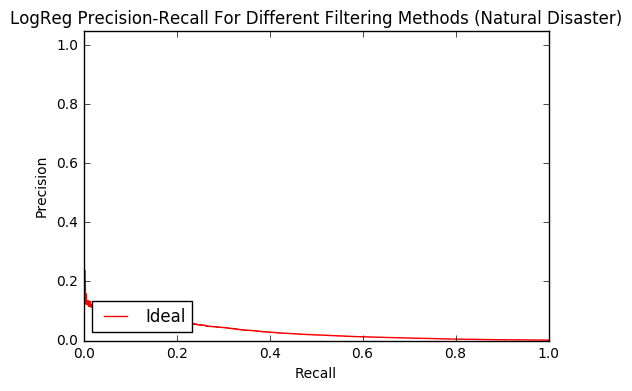

In [33]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
#plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
#plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

In [41]:
len(test[test.label == 0])

3170837

In [44]:
tf.get_pipeline().named_steps['classifier'].pre

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
pp = tf.get_pipeline()

In [46]:
f = test.drop('label', axis=1)
t = test['label']


pp.predict_proba(f)

array([[ 0.59088312,  0.40911688],
       [ 0.74169803,  0.25830197],
       [ 0.79777969,  0.20222031],
       ..., 
       [ 0.89047746,  0.10952254],
       [ 0.91214266,  0.08785734],
       [ 0.77896935,  0.22103065]])

In [48]:
test['scores'] = pp.predict_proba(f)[:, 1]

In [52]:
test['scores'].min()

1.08265741943401e-05

In [55]:
dp = DataPreprocessor(raw_data, "Health", load_labled=True, filter_empty_hashtags=True)

In [56]:
train, train_balanced, valid, valid_balanced, test = dp.temporal_split("Health", balance_data=True, remove_topic_hashtags=True)

[u'nurse', u'health', u'healthcare', u'uniteblue', u'unsg', u'aids', u'pandemic', u'hiv', u'depression', u'theplague', u'obesity', u'flu', u'virus', u'crisis', u'fever', u'lagos', u'alert', u'nih', u'publichealth', u'vaccine', u'childhoodobesity', u'westafrica', u'healthworkers', u'antivirus', u'malaria', u'flushot', u'tuberculosis', u'plague', u'healthsystems', u'allergy', u'msf', u'disease', u'sierraleone', u'mer', u'cdc', u'epidemic', u'homeopathy', u'dengue', u'childobesity', u'emory', u'ebola', u'chickenpox', u'meningitis', u'viruses', u'h1n1', u'quarantine', u'depressionhurts', u'coronavirus', u'allergyseason', u'birdflu', u'rotavirus', u'aidsfree', u'blackdeath', u'factsnotfear', u'depressionawareness', u'aids2014', u'chikungunya', u'stopthespread', u'mickeyvirus', u'chanyeolvirusday', u'aidsday', u'enterovirus', u'eplague']
[u'askebola', u'ebolaoutbreak', u'ebolavirus', u'truedepressioniswhen', u'ebolaresponse', u'humanitarianheroes', u'stopebola', u'ebolafacts', u'obola']
[u'e

In [57]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Health"

train_pd = train_balanced.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training2.csv", encoding='utf-8', index=False)

In [60]:
valid_pd = valid_balanced.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation2.csv", encoding='utf-8', index=False)

In [61]:
test_pd = test.toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test2.csv", encoding='utf-8', index=False)

In [58]:
len(test_pd)

3936905

In [24]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topics = ["Health"]

for topic in topics:
    print(topic)
    train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
#    train_unbalanced_pd = pd.read_csv(temporal_split_directory + topic + "/training_unbalanced.csv").dropna()
    validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation2.csv").dropna()
    test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

    test = test_pd.drop_duplicates(subset='term').reset_index()
    valid = validation_pd.drop_duplicates(subset='term').reset_index()
    train = train_pd.drop_duplicates(subset='term').reset_index()
#    train_unbalanced = train_unbalanced_pd.drop_duplicates(subset='term').reset_index()

    tf = TestFramework(train, valid, test)
    
    baseline, basic, mi, greedy, solver = get_selected_features(topic, tf, train)

Health


/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
#pos/#neg = 0.811904655759


In [25]:
tf.get_ideal_performance()

(1.0,
 1.0,
 0.79801428146726749,
 [array([ 0.02989664,  0.02989553,  0.02989557, ...,  1.        ,
          1.        ,  1.        ]),
  array([  1.00000000e+00,   9.99961836e-01,   9.99961836e-01, ...,
           7.63271381e-05,   3.81635691e-05,   0.00000000e+00])])

In [67]:
0.79779632720836102

2647057

In [70]:
len(test[test.label == 1])

2947

In [73]:
len(test[test.label == 1])

26203

In [20]:
baseline, basic, mi, greedy, solver = get_selected_features(topic, tf, train)

/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#pos/#neg = 0.74065915264


In [26]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()

filtered_baseline = tf.get_filtered_data_by_index(baseline)
_, _, baseline_avep, _ = tf.run_with_filtered_test_data(filtered_baseline) 

filtered_basic = tf.get_filtered_data_by_index(basic)
_, _, basic_avep, _ = tf.run_with_filtered_test_data(filtered_basic)

filtered_mi = tf.get_filtered_data_by_index(mi)
_, _, mi_avep, _ = tf.run_with_filtered_test_data(filtered_mi)

filtered_greedy = tf.get_filtered_data_by_index(greedy)
_, _, greedy_avep, _ = tf.run_with_filtered_test_data(filtered_greedy)

filtered_solver = tf.get_filtered_data_by_index(solver)
_, _, solver_avep, _ = tf.run_with_filtered_test_data(filtered_solver)


In [27]:
baseline_avep

0.99274012755197361

In [28]:
basic_avep

0.99980102258068237

In [29]:
greedy_avep

0.9626761531002237

In [30]:
solver_avep

0.99996516291855064

In [31]:
(float)(len(filtered_greedy[filtered_greedy.label == 1])) / len(filtered_greedy)

0.2369265117449137

In [32]:
len(test[test.label == 1])

26203

# Time

In [3]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Soccer"


train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

domain_stopwords = ['empty_location', 'empty_mention']#,'rt', 'amp', , 'http']
print("cov begin")
positive_set, negative_set = get_transformed_data(test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Initializing Classifier....
Complete!
cov begin
#pos/#neg = 0.0761043055235
184097
368194
transform done!


/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [20]:
import time

ns =  [20, 100, 500, 1000, 2000, 3000, 5000, 10000]
times = pd.DataFrame()

for n in ns:
    positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, n, negative_set=negative_set)

    num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
        get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)
    
    start_time = time.time()
    cailp = greedy_max_cover(positive_set_subset, negative_set_subset, tf.get_pipeline(), k=50)
    greedy_time = time.time() - start_time
    
    start_time = time.time()
    solver = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                           feature_negative_coverage_subset,\
                           num_positive_subset, num_negative_subset,\
                           k=50)
    gurobi_time = time.time() - start_time
    
    num_tweets = (int)(num_positive_subset) + num_negative_subset
    
    times = times.append(pd.DataFrame([[num_tweets, greedy_time, gurobi_time]]))

In [41]:
times

,0,1,2
0,60,21.846493,0.266252
0,300,20.086992,1.044912
0,1500,16.512309,14.382184
0,3000,16.979002,50.708418
0,6000,21.858028,199.412125
0,9000,22.826728,441.748627
0,15000,18.826690,1122.833224
0,30000,21.226196,4872.638384


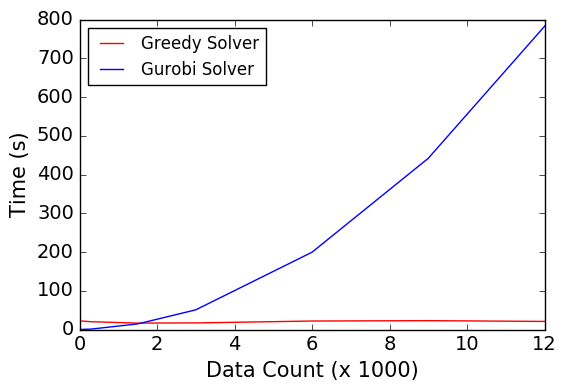

In [75]:
import matplotlib.pyplot as plt

plt.plot(times.iloc[:, 0]/1000, times.iloc[:, 1], label="Greedy Solver", color='r')
plt.plot(times.iloc[:, 0]/1000, times.iloc[:, 2], label="Gurobi Solver")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Data Count (x 1000)", fontsize=15)
plt.ylabel("Time (s)", fontsize=15)
plt.ylim([0, 800])
plt.xlim([0, 12])
plt.legend(loc=2)
plt.show()

In [42]:
times.iloc[:, 1]/100

0    0.218465
0    0.200870
0    0.165123
0    0.169790
0    0.218580
0    0.228267
0    0.188267
0    0.212262
Name: 1, dtype: float64

In [11]:
greedy_time

16.547924041748047

# Revision Tests

In [1]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

NameError: name 'API' is not defined

In [9]:
topics = ["Social_issue", "Space", "Soccer", "Human_Disaster", "Tennis", "Health", "LGBT"]
#"Natr_Disaster"]#,
#counts = pd.DataFrame()
for topic in topics:
    dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)
    train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True, balance_data=False)
    
    counts = counts.append(pd.DataFrame([[train.where(col('label') == 0).count(), train.where(col('label') == 1).count()\
                                , valid.where(col('label') == 0).count(), valid.where(col('label') == 1).count()]]))
    

Invalid Validation:19553
Invalid Test:15967
Invalid Validation:28353
Invalid Test:145766
Invalid Validation:88122
Invalid Test:272376
Invalid Validation:3766
Invalid Test:38930
Invalid Validation:4737
Invalid Test:14454
Invalid Validation:42568
Invalid Test:54729
Invalid Validation:1584
Invalid Test:406644
